# Финальный проект "Телеком"

Краткое описание: Необходимо научить модель прогнозировать отток клиентов, чтобы компания могла предложить этим клиентам бонусы, для повышения их лояльности. Дата выгрузки данных 1.02.2020.

Цель: Выбрать лучшую модель с лучшими гиперпараметрами, метрика AUC-ROC которой на тестовой выборке будет >= 0.85.

План:
1. Импорт и изучение данных
2. Исследовательский анализ данных
3. Обучение моделей
4. Тестирование модели
5. Общий вывод по проекту

## 1. Импорт и изучение данных:

In [20]:
# Загружу все необходимые библиотеки:
%pip install --upgrade scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install catboost

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/96/cf/a714a655266229b51eb2bda117f15275f12457887f165f3c1cc58ab502f1/scikit_learn-1.3.0-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.2 MB 656.4 kB/s eta 0:00:14
   ---------------------------------------- 0.1/9.2 MB 656.4 kB/s eta 0:00:14
    --------------------------------------- 0.1/9.2 MB 514.3 kB/s eta 0:00:18
    --------------------------------------- 0.2/9.2 MB 573.4 kB/s eta 0:00:16
    --------------------------------------- 0.2/9.2 MB 573.4 kB/s eta 0:00:16
   - -------------------------------------- 0.2/9.2 MB 627.5 kB/s eta 0:00:15
   - -------------------------------------- 0.3/9.2 MB 630.9 kB/s eta 0:00:15
   - ------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\amish\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\~-learn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортирую все необходимые библиотеки:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn

import warnings

import time 

import sklearn

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)


from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV



warnings.filterwarnings("ignore")

RND = 100423

In [3]:
# Загружу данные:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

Изучу по какому столбцу можно объединить данные, так как далее изучать датасет, и работать с ними легче совместно.

In [4]:
# Изучу, по какому столбцу можно объединить данные:
display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [5]:
# Объединить нужно таблицы по столбцу customerID:
data = contract.merge(personal, on='customerID', how = 'left')
data = data.merge(internet, on='customerID', how = 'left')
data = data.merge(phone, on='customerID', how = 'left')

# Проверю, насколько успешно объединились таблицы:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [6]:
# Изучу датасет:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


В датасете 4835 строк, и 19 столбцов. Необходимо обработать пропуски, потому что они точно будут из-за объединения столбцов. Так же необходимо поработать со столбцами BeginDate и EndDate - определю по ним длительность действия договора, и удалю эти столбцы.

In [7]:
# Добавлю колонку с целевым признаком, отражающим факт ухода уклиента.
data['turnover'] = (data['EndDate'] != 'No').astype(int)

data['turnover'].unique()

array([0, 1])

Теперь можно поработать со столбцами begindate и enddate, а после - удалить их за ненадобностью, чтобы модель не переобучалась.

Посчитаем длительность контракта:

In [8]:
# Заменю все значения "No" в EndDate на дату выгрузки датасета (01.02.2020) 
data['EndDate'] = data['EndDate'].replace(['No'], ['2020-02-01'])
print(data[data['EndDate'] == 'No'].shape[0])

# Переведу EndDate и BeginDate в формат даты:
data['EndDate'] = pd.to_datetime(data['EndDate'], errors='coerce')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], errors='coerce')

# Создам столбец, в котором будет длительность контракта: 
data.insert(0,"Days", " ")

#  Вычту BeginDate от EndDate, чтобы рассчитать длительность контракта: 
data['Days'] = (data['EndDate'] - data['BeginDate']).dt.days

# Проверка: 
data.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Days              7043 non-null   int32         
 1   customerID        7043 non-null   object        
 2   BeginDate         7043 non-null   datetime64[ns]
 3   EndDate           7043 non-null   datetime64[ns]
 4   Type              7043 non-null   object        
 5   PaperlessBilling  7043 non-null   object        
 6   PaymentMethod     7043 non-null   object        
 7   MonthlyCharges    7043 non-null   float64       
 8   TotalCharges      7043 non-null   object        
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517

In [9]:
# Удалю неинформативные столбцы:
data.drop(['BeginDate', 'EndDate', 'customerID'], axis='columns', inplace=True)

# Проверка:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Days              7043 non-null   int32  
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   5517 non-null   object 
 11  OnlineSecurity    5517 non-null   object 
 12  OnlineBackup      5517 non-null   object 
 13  DeviceProtection  5517 non-null   object 
 14  TechSupport       5517 non-null   object 
 15  StreamingTV       5517 non-null   object 
 16  StreamingMovies   5517 non-null   object 


### Работа с пропусками и аномальными данными:

Пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines скорее всего означают, что услуги не подключены.

In [10]:
# Заменим пропуски на "No": 
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    data[column] = data[column].fillna('No')

# Проверка:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Days              7043 non-null   int32  
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


### Проверю числовые признаки на наличие мультиколлинеарности:

In [11]:
# Переведу TotalCharges в числовой тип:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors ='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Days              7043 non-null   int32  
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


In [13]:
# Вынесу столбцы с количественными признаками: 
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'Days']
# Выведу корреляцию между всеми количественными данными:
data[numeric_columns].corr()

,MonthlyCharges,TotalCharges,Days
MonthlyCharges,1.000000,0.630297,0.220054
TotalCharges,0.630297,1.000000,0.821442
Days,0.220054,0.821442,1.000000


Присутствует проблема мультиколлинеарности в данных - корреляция между TotalCharges и Days - 0.82.

In [14]:
# Поле TotalCharges можно удалить:
data.drop(['TotalCharges'], axis='columns', inplace=True)

### Разделение датасета на тестовую и тренировочную выборки:

In [15]:
# Выделю фичи и таргет:
target = data['turnover'] 
features = data.drop(columns=['turnover'])

# Разделю датасет на тестовую и обучающую выборки:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RND)

In [16]:
# Выделю категориальные признаки:
cat_columns = features_train.select_dtypes(include='object').columns.to_list()
print(cat_columns)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [17]:
# Выделю числовые признаки:
numeric = features_train.select_dtypes(exclude='object').columns.to_list()
numeric

['Days', 'MonthlyCharges', 'SeniorCitizen']

### Масташибрование и кодирование данных, посредством OneHotEncoder, StandardScaler:

Кодировать нужно после разделения на выборки, т.к. в тестовой могут быть категории, которых не было в обучающей. 

In [22]:
# Посредством OHE закодирую категориальные признаки:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse = False)
ohe.fit(features_train_ohe[cat_columns])

features_train_ohe[ohe.get_feature_names_out()] = ohe.transform(features_train_ohe[cat_columns])

features_train_ohe = features_train_ohe.drop(cat_columns, axis = 1)

features_test_ohe[ohe.get_feature_names_out()] = ohe.transform(features_test_ohe[cat_columns])

features_test_ohe = features_test_ohe.drop(cat_columns, axis = 1)

In [23]:
# Отмасштабирую количественные признаки:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

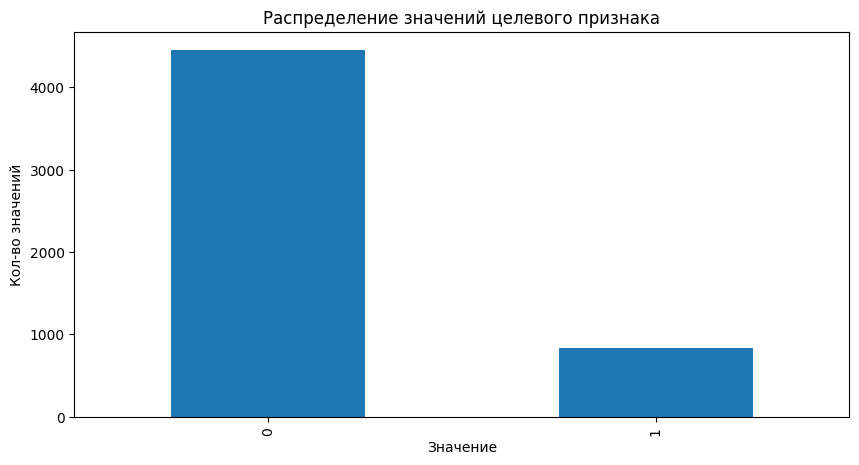

In [24]:
# Проверю баланс классов:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

Метрика ROC-AUC не чувствительна к дисбалансу, поэтому ничего критичного в этой картине нет. Учтем баланс классов внутри моделей посредством параметра (class_weight = 'balanced'). 

## 2. Исследовательский анализ

### 2.1 Изучение датасета на графиках:

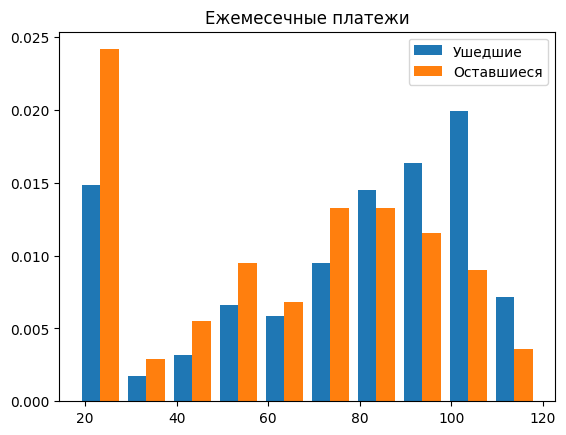

In [25]:
# Посмотрю на зависимость оттока клиентов от ежемесячных платежей: 
plt.hist([data[data.turnover == 1].MonthlyCharges, data[data.turnover == 0].MonthlyCharges], label=['Ушедшие', 'Оставшиеся'], density=True);
plt.legend();
plt.title('Ежемесечные платежи');
plt.show();

Чаще уходят клиенты, ежемесячные платежи которых достаточно высоки (70-100).

<Axes: >

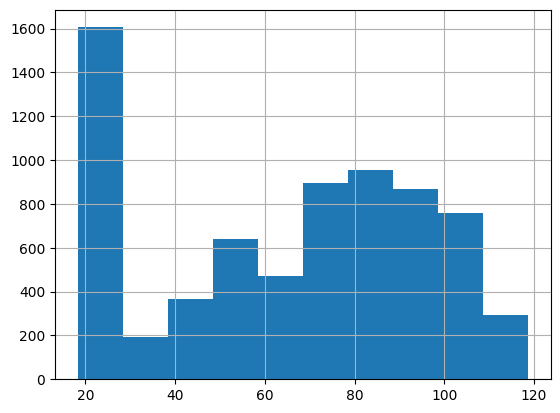

In [26]:
# Посмотрю на общее распределение данных в этом столбце:
data['MonthlyCharges'].hist()

Всё же большинство клиентов платят меньше 30. Значит этот признак не так сильно влияет на общую картину оттока клиентов.

### 2.2 Изучение зависимости целевого признака от остальных признаков:

<Axes: title={'center': 'Интернет:'}, xlabel='InternetService'>

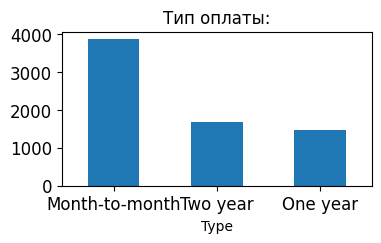

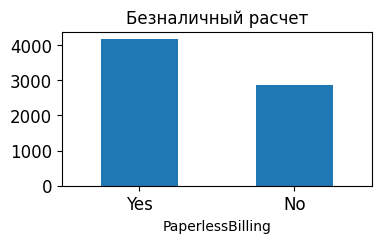

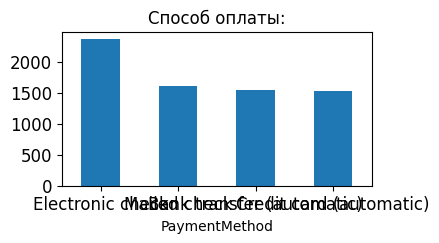

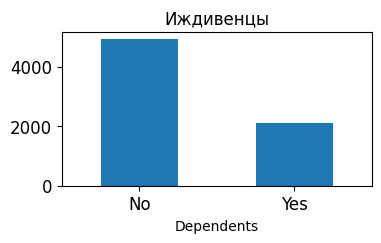

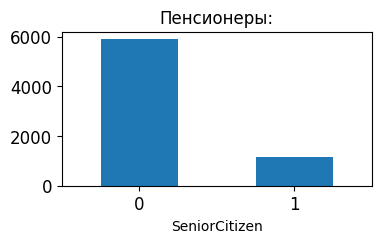

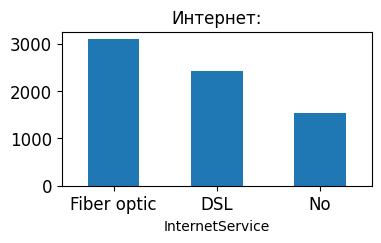

In [27]:
plt.figure(figsize=(4,2))
data['Type'].value_counts().plot(kind='bar',
                              title = 'Тип оплаты:',
                              rot=0,
                              fontsize =12)

plt.figure(figsize=(4,2))
data['PaperlessBilling'].value_counts().plot(kind='bar',
                              title = 'Безналичный расчет',
                              rot=0,
                              fontsize =12
                                           )

plt.figure(figsize=(4,2))
data['PaymentMethod'].value_counts().plot(kind='bar',
                              title = 'Способ оплаты:',
                              rot=0,
                              fontsize =12
                                           )

plt.figure(figsize=(4,2))
data['Dependents'].value_counts().plot(kind='bar',
                              title = 'Иждивенцы',
                              rot=0,
                              fontsize =12
                                           )

plt.figure(figsize=(4,2))
data['SeniorCitizen'].value_counts().plot(kind='bar',
                              title = 'Пенсионеры:',
                              rot=0,
                              fontsize =12
                                           )

plt.figure(figsize=(4,2))
data['InternetService'].value_counts().plot(kind='bar',
                              title = 'Интернет:',
                              rot=0,
                              fontsize =12
                                           )

Уходят чаще те клиенты, у которых тип оплаты помесячный + иждивенцы  + пенсионеры.

Также интересно, что при электронной оплате отток клиентов выше, возможно какие-то трудности с этим способом оплаты.

## 3. Обучение моделей

### 3.2 Обучение модели градиентого бустинга CatBoostClassifier c определением AUC-ROC на тестовой выборке:

In [28]:
# Подберем лучшие гиперпараметры для модели CatBoostClassifier:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [100, 500],
    'l2_leaf_reg': [3, 9]
}

model_cat = CatBoostClassifier(random_state=RND, verbose=0)

search = GridSearchCV(model_cat, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train_ohe, target_train)

print('Лучший roc/auc:', search.best_score_, 'при', search.best_params_)

Лучший roc/auc: 0.9086516922228618 при {'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


3.3 Обучение модели RandomForestClassifier c подбором лучших гиперпараметром с помощью GridSearchCV и с определением AUC-ROC:

In [29]:
# Подберем лучшие гиперпараметры для модели RandomForestClassifier:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=RND)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train_ohe, target_train)

print('Лучший roc/auc:', search.best_score_, 'при', search.best_params_)

Лучший roc/auc: 0.8204993778673512 при {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


3.4 Обучение модели LogisticRegression c подбором лучших гиперпараметром с помощью GridSearchCV и с определением AUC-ROC:

In [30]:
# Подберем лучшие гиперпараметры для модели LogisticRegression:
model_lr = LogisticRegression(C=0.5)
roc_auc_lr_v = cross_val_score(model_lr, features_train_ohe, target_train, cv=5, scoring='roc_auc').mean()
print(f"roc_auc для модели Логистической Регрессии на кросс-валидации: {roc_auc_lr_v:.3f}")

roc_auc для модели Логистической Регрессии на кросс-валидации: 0.755


3.5 Качество лучшей модели проверим кросс-валидацией:

In [31]:
# кросс-валидация CatBoostRegressor:
model_test = CatBoostClassifier(random_state=RND, verbose=0, iterations = 500, l2_leaf_reg = 3, learning_rate = 0.1)

model_test.fit(features_train_ohe, target_train)

score = cross_val_score(model_test, features_train_ohe, np.array(target_train), scoring = 'roc_auc', cv=6).mean()
print('CatBoostClassifier ROC-AUC:', abs(score))

CatBoostClassifier ROC-AUC: 0.9128342294899418


## 4. Тестирование модели

4.1 Проверю лучшую модель с оптимальными гиперпараметрами на тестовой выборке, ориентация на AUC-ROC, метрика должна быть >=0.85.

In [32]:
pred_test_cat = model_test.predict_proba(features_test_ohe)[:, 1]
print('ROC-AUC: ',roc_auc_score(target_test, pred_test_cat))

ROC-AUC:  0.9230103936344629


## 5. Общий вывод по проекту

Я изучила 4 датасета, объединила их в один общий датасет по ID клиента. Подготовила данные, удалив пропуски, ненужные признаки-столбцы, нашла общий срок длительности контракта каждого клиента. Добавила колонку с целевым признаком, отражающим факт ухода уклиента. Решила проблему мультиколлинеарности. Пропуски в столбцах, которые интерпретированы как "услуги не подключены", заменила на "No". Провела исследовательский анализ данных, в которых обнаружила связь между типом оплаты (ежемесячно), наличием иждивенцев, пенсионер - такие клиенты чаще уходят, не продлевают контракт. Так же выяснилось, что чаще уходят клиенты, которые осущес твляют ежемесячно достаточно высокие платежи (70-100). Но большинство клиентов платт меньше 30, поэтому этот признак не так сильно влияет на уход, скорее всего. Также интересно, что при электронной оплате отток клиентов выше, возможно какие-то трудности с этим способом оплаты. Затем я разделила датасет на тестовую и обучающую выборки, и провела кодирование и масштабирование данных посредством посредством OneHotEncoder, StandardScaler. Обнаружила дисбаланс классов, но метрики ROC-AUC не чувствительна к дисбалансу. Следом я обучила 3 модели (CatBoostClassifier, RandomForestClassifier, LogisticRegression) для предсказания оттока клиентов с подбором гиперпараметров посредством GridSearchCV. Лучшее значение метрики ROC-AUC получилось у CatBoostClassifier с гиперпараметрами {'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}. Проверила эту модель на тестовой выборке и убедилась в том, что модель обучена корректно, и метрика ROC-AUC >= 0.85 (а именно: 0.92). - Это отличный результат!